In [1]:
import pandas as pd
import numpy as np
import os
import random
import deepchem as dc
import tensorflow as tf

Skipped loading some Pytorch utilities, missing a dependency. No module named 'torch'


This module requires PyTorch to be installed.


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [71]:
#Importing ESOL Delaney solubility dataset 

tasks, datasets, transformers = dc.molnet.load_delaney(featurizer="GraphConv", splitter="random")
train_dataset, valid_dataset, test_dataset = datasets
train_dataframe = train_dataset.to_dataframe()
print(train_dataframe.head)

<bound method NDFrame.head of                                                      X         y    w  \
0    <deepchem.feat.mol_graphs.ConvMol object at 0x...  0.038124  1.0   
1    <deepchem.feat.mol_graphs.ConvMol object at 0x...  0.210134  1.0   
2    <deepchem.feat.mol_graphs.ConvMol object at 0x...  0.151537  1.0   
3    <deepchem.feat.mol_graphs.ConvMol object at 0x... -0.764750  1.0   
4    <deepchem.feat.mol_graphs.ConvMol object at 0x...  0.283853  1.0   
..                                                 ...       ...  ...   
897  <deepchem.feat.mol_graphs.ConvMol object at 0x... -0.694339  1.0   
898  <deepchem.feat.mol_graphs.ConvMol object at 0x...  0.272512  1.0   
899  <deepchem.feat.mol_graphs.ConvMol object at 0x...  0.884000  1.0   
900  <deepchem.feat.mol_graphs.ConvMol object at 0x... -0.292666  1.0   
901  <deepchem.feat.mol_graphs.ConvMol object at 0x...  0.789489  1.0   

                                           ids  
0               CN(C)C(=O)C(c1ccccc1)c2ccccc

In [73]:
#Featurise data

from rdkit import Chem

featurizer = dc.feat.CircularFingerprint(size=2048, radius=4)
X = featurizer.featurize(train_dataframe["ids"])
y = train_dataframe["y"] #Solubility 


[17:10:03] DEPRECATION WARNING: please use MorganGenerator
[17:10:03] DEPRECATION WARNING: please use MorganGenerator
[17:10:03] DEPRECATION WARNING: please use MorganGenerator
[17:10:03] DEPRECATION WARNING: please use MorganGenerator
[17:10:03] DEPRECATION WARNING: please use MorganGenerator
[17:10:03] DEPRECATION WARNING: please use MorganGenerator
[17:10:03] DEPRECATION WARNING: please use MorganGenerator
[17:10:03] DEPRECATION WARNING: please use MorganGenerator
[17:10:03] DEPRECATION WARNING: please use MorganGenerator
[17:10:03] DEPRECATION WARNING: please use MorganGenerator
[17:10:03] DEPRECATION WARNING: please use MorganGenerator
[17:10:03] DEPRECATION WARNING: please use MorganGenerator
[17:10:03] DEPRECATION WARNING: please use MorganGenerator
[17:10:03] DEPRECATION WARNING: please use MorganGenerator
[17:10:03] DEPRECATION WARNING: please use MorganGenerator
[17:10:03] DEPRECATION WARNING: please use MorganGenerator
[17:10:03] DEPRECATION WARNING: please use MorganGenerat

In [74]:
#Train test split 

from sklearn.model_selection import train_test_split
seed = random.seed(400)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [83]:
#Train the model

from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

reg = GradientBoostingRegressor(random_state=seed)
reg.fit(X_train, y_train)
print(cross_val_score(reg, X_train, y_train, cv=3, n_jobs=-1).mean())

0.5941931800814548


In [ ]:
#Optional Optimisation

param_grid = {
    "n_estimators": [10, 50, 100, 500],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
    "max_depth":[3, 5, 7, 9],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "min_samples_split": [2, 4, 6, 8, 10], 
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0]
}

reg2 = GridSearchCV(reg, param_grid, cv=3, n_jobs=-1)

search = RandomizedSearchCV(reg, param_distributions= param_grid, n_iter=100, cv=3, n_jobs=-1, verbose=2)
search.fit(X_train, y_train)

print(f"Best Training Parametres: {search.best_params_}")
print(f"Best Training Score: {search.best_score_}")

In [87]:
#Actual Test data 

test_param_grid = {
    "n_estimators": [500],
    "learning_rate": [0.1],
    "max_depth":[7],
    "min_samples_leaf": [4],
    "min_samples_split": [6], 
    "subsample": [0.7]
}

test_regression = GridSearchCV(reg, test_param_grid, cv=3, n_jobs=-1)
test_regression.fit(X_test, y_test)

print(f"Best Test Score: {test_regression.best_score_}")

Best Test Score: 0.4306023615503242


In [ ]:
#Creating a test dataset 

In [25]:
predicted_solubility = test_regression.predict(X_test)

In [27]:
import matplotlib.pyplot as plt

In [28]:
from sklearn import metrics

In [29]:
from sklearn.metrics import root_mean_squared_error

In [30]:
root_mean_squared_error(predicted_solubility, y_test)

0.07342241379776018

In [31]:
predicted_RMSE = root_mean_squared_error(predicted_solubility, y_test)
rounded_RMSE = round(predicted_RMSE, 3)

In [32]:
y_test

886   -1.038833
459    2.192982
607    1.044669
268   -0.272819
661   -2.013245
         ...   
141   -2.524079
235    0.397267
785    0.751684
255   -0.743485
788    0.935981
Name: y, Length: 181, dtype: float64

In [33]:
from sklearn.metrics import r2_score

In [34]:
predicted_r2_score = r2_score(predicted_solubility, y_test)
rounded_r2 = round(predicted_r2_score, 3)

In [35]:
predicted_r2_score

0.9950044625551484

In [36]:
print(predicted_solubility.shape, y_test.shape)

(181,) (181,)


In [37]:
print(type(predicted_solubility), type(y_test))

<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [38]:
import numpy as np

In [39]:
print("NaNs:", np.isnan(y_test).any())
print("Infs:", np.isinf(y_test).any())

NaNs: False
Infs: False


In [40]:
print("NaNs:", np.isnan(np.array(predicted_solubility)).any())
print("Infs:", np.isinf(np.array(predicted_solubility)).any())

NaNs: False
Infs: False


In [41]:
print(y_test.dtype)

float64


In [42]:
print(predicted_solubility.dtype)

float64


Text(0.9, 0.2, 'R-squared = 0.995\nRMSE = 0.073')

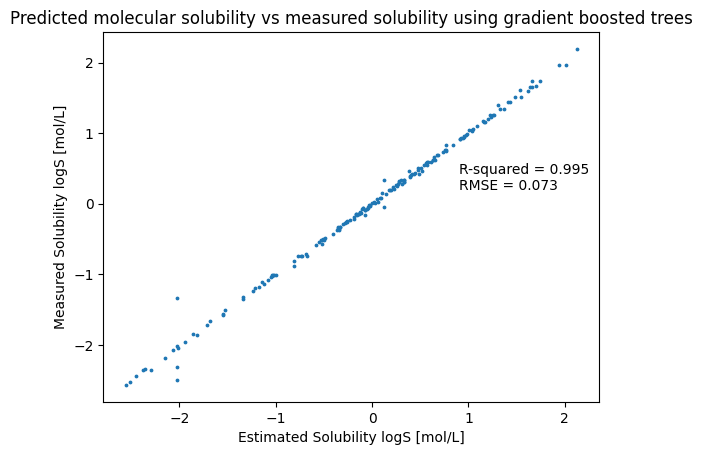

In [43]:
plt.scatter(np.array(predicted_solubility), y_test, s=3) #x, y
plt.title("Predicted molecular solubility vs measured solubility using gradient boosted trees")
plt.xlabel("Estimated Solubility logS [mol/L]")
plt.ylabel("Measured Solubility logS [mol/L]")
plt.text(0.9, 0.2, 'R-squared = %.3f\nRMSE = %.3f' % (predicted_r2_score, predicted_RMSE))

In [ ]:
#residual plot
#histogram
#Feature importance
#Predicted vs true line of equality
#error vs molecular size?

In [44]:
import seaborn as sns

In [45]:
residual_df = pd.DataFrame({"Estimated Solubility logS [mol/L]" : predicted_solubility, "Measured Solubility logS [mol/L]" : y_test})
residual_df["Residuals"] = residual_df["Estimated Solubility logS [mol/L]"] - residual_df["Measured Solubility logS [mol/L]"]

Text(0, 0.5, 'Residuals (Predicted - Measured)')

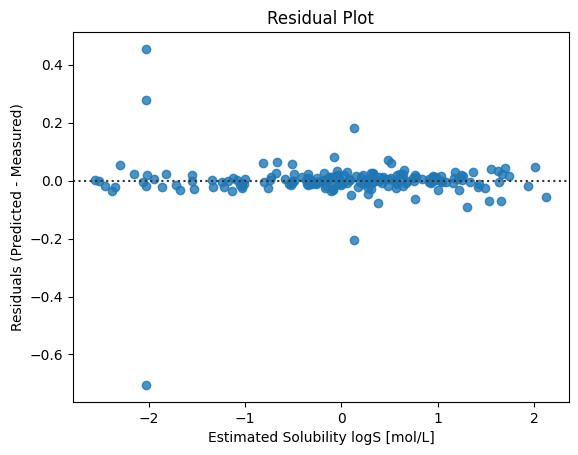

In [66]:
sns.residplot(x="Estimated Solubility logS [mol/L]", y="Residuals", data=residual_df)
plt.title("Residual Plot")
plt.xlabel("Estimated Solubility logS [mol/L]")
plt.ylabel("Residuals (Predicted - Measured)")

In [ ]:
#################################################################
#Featture importance 

In [56]:
best_model = test_regression.best_estimator_ #Get trained model with best hyperparametres 

In [57]:
importances = best_model.feature_importances_ #GB assigns numerical importance to each feature

In [61]:
#Converting X-train numpy array to DataFrame for mapping feature importance 
X_train_df = pd.DataFrame(X_train, columns=[f"Feature {i}" for i in range(X_train.shape[1])])
feature_names = X_train_df.columns

In [63]:
#Create dataframe for plotting 
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)

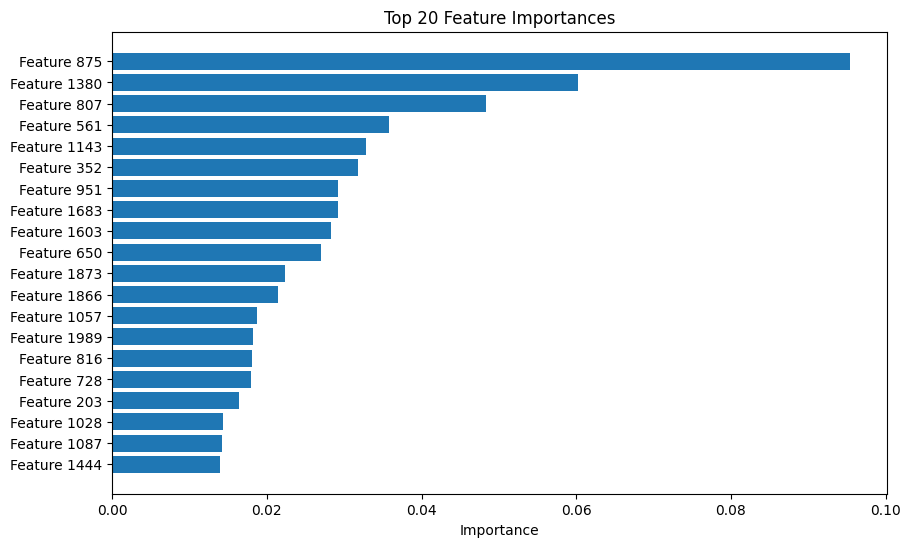

In [64]:
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['Feature'][:20], feat_imp_df['Importance'][:20])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.show()